In [12]:
# Initial setup and imports
import os
import gc
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Enable GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("No GPUs found, using CPU")

print(f"TensorFlow version: {tf.__version__}")


No GPUs found, using CPU
TensorFlow version: 2.19.0


In [13]:
# Configuration - reduced sizes to prevent memory issues
IMG_SIZE = 256  # Reduced from 512 to prevent memory issues
BATCH_SIZE = 4  # Small batch size for memory efficiency
NUM_CLASSES = 4  # 0=Soil, 1=Sand, 2=Bedrock, 3=Big Rock
BUFFER_SIZE = 1000
EPOCHS = 5  # Start with fewer epochs for testing

# Dataset paths
TRAIN_IMG_DIR = "dataset/train/images"
TRAIN_MASK_DIR = "dataset/train/masks"
TEST_IMG_DIR = "dataset/test/images"
TEST_MASK_DIR = "dataset/test/masks"

# Verify dataset existence and count files
for dir_path in [TRAIN_IMG_DIR, TRAIN_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR]:
    if os.path.exists(dir_path):
        count = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{dir_path}: {count} files")
    else:
        print(f"ERROR: {dir_path} does not exist!")

# Define color map for visualization
colormap = {
    0: (139, 69, 19),    # Brown (Soil)
    1: (255, 255, 0),    # Yellow (Sand)
    2: (128, 128, 128),  # Gray (Bedrock)
    3: (255, 0, 0),      # Red (Big Rock)
}

dataset/train/images: 12851 files
dataset/train/masks: 12851 files
dataset/test/images: 3213 files
dataset/test/masks: 3213 files


In [14]:
# CRITICAL FIX: Preprocessing function that handles mask values of 255
def preprocess_image(image_path, mask_path):
    """Memory-efficient preprocessing function using TensorFlow ops"""
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask, axis=-1)  # Remove channel dimension
    
    # CRITICAL: Remap 255 values to 0 (valid class index)
    # This fixes the "label value of 255 outside valid range [0, 4)" error
    mask = tf.where(mask == 255, 0, mask)
    
    # Resize
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask[..., tf.newaxis], [IMG_SIZE, IMG_SIZE], method='nearest')
    mask = tf.squeeze(mask, axis=-1)
    
    return image, mask

def create_dataset(image_dir, mask_dir, is_training=True):
    """Create tf.data.Dataset with efficient preprocessing"""
    # Get file paths
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
    mask_files = [f.replace('.JPG', '.png').replace('.jpg', '.png') for f in image_files]
    
    image_paths = [os.path.join(image_dir, f) for f in image_files]
    mask_paths = [os.path.join(mask_dir, f) for f in mask_files]
    
    # Verify files exist
    valid_pairs = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_pairs.append((img_path, mask_path))
    
    print(f"Found {len(valid_pairs)} valid image-mask pairs in {image_dir}")
    
    image_paths, mask_paths = zip(*valid_pairs)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(mask_paths)))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(BUFFER_SIZE)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


In [15]:
# Create datasets and test data loading
print("Creating training dataset...")
train_dataset = create_dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, is_training=True)

print("Creating test dataset...")
test_dataset = create_dataset(TEST_IMG_DIR, TEST_MASK_DIR, is_training=False)

# Calculate dataset sizes
train_size = len([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])
test_size = len([f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = test_size // BATCH_SIZE

print(f"Training samples: {train_size}, Steps per epoch: {steps_per_epoch}")
print(f"Test samples: {test_size}, Validation steps: {validation_steps}")

# Test data loading and verify mask values are now in valid range
print("\nTesting data loading...")
for batch_images, batch_masks in train_dataset.take(1):
    print(f"Batch shape - Images: {batch_images.shape}, Masks: {batch_masks.shape}")
    print(f"Image dtype: {batch_images.dtype}, range: [{tf.reduce_min(batch_images):.3f}, {tf.reduce_max(batch_images):.3f}]")
    print(f"Mask dtype: {batch_masks.dtype}, range: [{tf.reduce_min(batch_masks)}, {tf.reduce_max(batch_masks)}]")
    
    # Check unique mask values to ensure 255 is remapped
    unique_values = tf.unique(tf.reshape(batch_masks, [-1]))[0]
    print(f"Unique mask values in batch: {unique_values.numpy()}")
    
    if tf.reduce_max(batch_masks) >= NUM_CLASSES:
        print("ERROR: Mask values still outside valid range!")
    else:
        print("✓ All mask values are now in valid range [0, 3]")

# Clean up memory
gc.collect()
print("\nData loading test completed successfully!")


Creating training dataset...
Found 12851 valid image-mask pairs in dataset/train/images
Creating test dataset...
Found 3213 valid image-mask pairs in dataset/test/images
Training samples: 12851, Steps per epoch: 3212
Test samples: 3213, Validation steps: 803

Testing data loading...
Batch shape - Images: (4, 256, 256, 3), Masks: (4, 256, 256)
Image dtype: <dtype: 'float32'>, range: [0.009, 1.000]
Mask dtype: <dtype: 'int32'>, range: [0, 2]
Unique mask values in batch: [0 1 2]
✓ All mask values are now in valid range [0, 3]

Data loading test completed successfully!


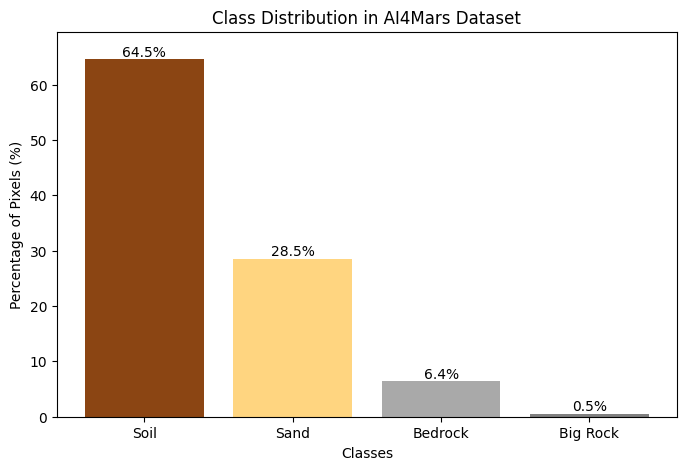

In [17]:
import numpy as np
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt

# Counter for all pixels in dataset
class_counts = Counter()

# Assuming you already have a dataset in the form: for image, mask in dataset:
for image, mask in test_dataset:  # dataset yields (image, mask) pairs
    true_mask = mask[0]  # shape: (H, W) or (H, W, 1)
    true_class_mask = true_mask.numpy().squeeze()  # shape: (H, W)
    
    # Count pixels per class in this mask
    unique, counts = np.unique(true_class_mask, return_counts=True)
    for cls, count in zip(unique, counts):
        class_counts[int(cls)] += int(count)

for image, mask in train_dataset:  # dataset yields (image, mask) pairs
    true_mask = mask[0]  # shape: (H, W) or (H, W, 1)
    true_class_mask = true_mask.numpy().squeeze()  # shape: (H, W)
    
    # Count pixels per class in this mask
    unique, counts = np.unique(true_class_mask, return_counts=True)
    for cls, count in zip(unique, counts):
        class_counts[int(cls)] += int(count)

# Map class IDs to names (AI4Mars labeling)
class_labels = {
    0: "Soil",
    1: "Sand",
    2: "Bedrock",
    3: "Big Rock"
}

# Convert counts to percentages
# Convert to lists for plotting
classes = [class_labels[c] for c in sorted(class_counts.keys())]
counts = [class_counts[c] for c in sorted(class_counts.keys())]

# Percentages
total_pixels = sum(counts)
percentages = [(count / total_pixels) * 100 for count in counts]

# Plot bar graph
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, percentages, color=['#8B4513', '#FFD580', '#A9A9A9', '#808080'])
plt.xlabel("Classes")
plt.ylabel("Percentage of Pixels (%)")
plt.title("Class Distribution in AI4Mars Dataset")
plt.ylim(0, max(percentages) + 5)

# Annotate bars with percentages
for bar, pct in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{pct:.1f}%", ha='center', va='bottom', fontsize=10)

plt.show()